<h1>Measuring Properties of Ball Spring Solid</h1>
<h2>Thomas M. Boudreaux</h2>

In [1]:
from IPython.display import HTML

def playVideo(path):
    return HTML("""
                <video width="320" height="240" controls>
                  <source src="{}" type="video/mp4">
                </video>
                """.format(path))

<h3>What do we want to measure</h3>

<h4>Youngs Modulus</h4><br>
    - A measure of the stiffness of a material

$$
E = \frac{Stress}{Strain}
$$

$$
Stress = \frac{A}{F} \;\;\;\;\;\;\;\;\;\;\;\;\;\;Strain = \frac{\Delta L}{L}
$$

<h4>Coefficient of Restitution</h4><br>
    - A measure of kinetic energy lost in collision

$$
e = \sqrt{\frac{T_{i}}{T_{f}}}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mplEasyAnimate import animation
from tqdm import tqdm
from scipy.special import comb
from scipy.special import factorial
from numba import njit, jit

In [3]:
@njit
def rk4(y0, IDx, IDy, h, sep, pList, massList, ts, b, k, F):
    k1 = h*nbody(y0, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k2 = h*nbody(y0+k1/2, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k3 = h*nbody(y0+k2/2, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    k4 = h*nbody(y0+k3, IDx, IDy, h, sep, pList, massList, ts, b, k, F)
    return y0 + (k1/6)+(k2/3)+(k3/3)+(k4/6)

In [4]:
@njit
def getVecs(r1, r2):
    sr = r2-r1
    srmag = np.sqrt(sr[0]**2+sr[1]**2)
    return sr, srmag, sr/srmag

In [5]:
@njit
def getForceComponents(r, v, pList, IDx, IDy, k, b, sep, xoffsets, yoffsets, ts):
    FMag = np.zeros(shape=(2,))
    for oID in range(len(xoffsets)):
        dx = xoffsets[oID]
        dy = yoffsets[oID]
        sr, srmag, srhat = getVecs(r, pList[IDx+dx, IDy+dy, :2])
        if srmag > 0.1:
            FMag += -k*(sep-srmag)*srhat-b*v
    return FMag

<h3>Model</h3>

<img src="PresentationFigures/BallSpring.png" alt="Drawing" style="width: 500px;"/>

<h3>Boundary Conditions</h3>
There are eight boundary conditions we need to handel seperatly

    1) Corners (4x)
    2) Edges (4x)
    3) Remainder

<h3>Corners</h3>

In [ ]:
    if IDx == IDy == 0:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [1, 0], [0, 1], ts)
        FMag = np.array([0.0, 0.0])

    elif IDx == pList.shape[0]-1 and IDy == pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0], [0, -1], ts) + F
        
    elif IDx == 0 and IDy == pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [1, 0], [0, -1], ts)
        FMag = np.array([0.0, 0.0])

    elif IDx == pList.shape[0]-1 and IDy == 0:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0], [0, 1], ts) + F

<h3>Edges</h3>

In [ ]:
    elif IDy == 0 and IDx != 0 and IDx != pList.shape[0]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0, 1], [0, 1, 0], ts)

    elif IDy == pList.shape[1]-1 and IDx != 0 and IDx != pList.shape[0]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [-1, 0, 1], [0, -1, 0], ts)

    elif IDx == 0 and IDy != 0 and IDy != pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, 1, 0], [-1, 0, 1], ts)
        FMag = np.array([0.0, 0.0])
        
    elif IDx == pList.shape[0]-1 and IDy != 0 and IDy != pList.shape[1]-1:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, -1, 0], [-1, 0, 1], ts) + F

<h3>All Other Particles</h3>

In [ ]:
    else:
        FMag = getForceComponents(r, v, pList, IDx, IDy, k, b, sep, [0, 1, 0, -1], [-1, 0, 1, 0], ts)

In [7]:
def int_n_model(pList, mass, sep, h, tf=1, b=0.2, k=10, F=np.array([0,0]), pbar=True):
    ts = np.arange(0, tf, h)
    ys = np.zeros(shape=(len(ts)+1, pList.shape[0], pList.shape[1], pList.shape[2]))
    ys[0] = pList

    for i in tqdm(range(ts.shape[0]), disable=not pbar):
        for IDx in range(ys[i, :].shape[0]):
            for IDy in range(ys[i, :].shape[1]):
                ys[i+1, IDx, IDy] = rk4(ys[i, IDx, IDy], IDx, IDy, h, sep, ys[i, :, :], massList, i, b, k, F)
    return np.arange(0, tf+h, h), ys

In [8]:
def make_lattice(Nv, Nh, sep):
    lattice = np.zeros(shape=(Nv, Nh, 4))
    for nv in range(Nv):
        for nh in range(Nh):
            lattice[nh, nv] = np.array([nh*sep, nv*sep, 0, 0])
    
    return lattice

In [9]:
def plot_system(y, F=None):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    ax.plot(y[:, 1:-1, 0], y[:, 1:-1, 1], 'C0o')
    if F:
        ax.quiver(y[-1, 1:-1, 0], y[-1, 1:-1, 1], F[0], F[1])
    return fig, ax

In [10]:
def animate_system(filename, ys, F=None, skip=1):
    anim = animation(filename, fps=30)
    for i, y in tqdm(enumerate(ys), total=ys.shape[0]):
        if i%skip == 0:
            fig, ax = plot_system(y, F=F)
            ax.set_xlim(np.min(ys[:, 0, 0])-0.1, np.max(ys[:, -1, 0])+0.1)
            ax.set_ylim(np.min(ys[0, :, 1])-0.1, np.max(ys[-1, :, 1])+0.1)
            anim.add_frame(fig)
            plt.close(fig)
    
    anim.close()

<h3>Initial Contidions</h3>
I defined helper funcions to build a latice of particles seperated by the equilibrium length some spring I connecte them with

In [11]:
sep=1
n = 10
lattice = make_lattice(n, n, sep)
massList = np.ones(shape=(n, n))
F = np.array([0, 0])

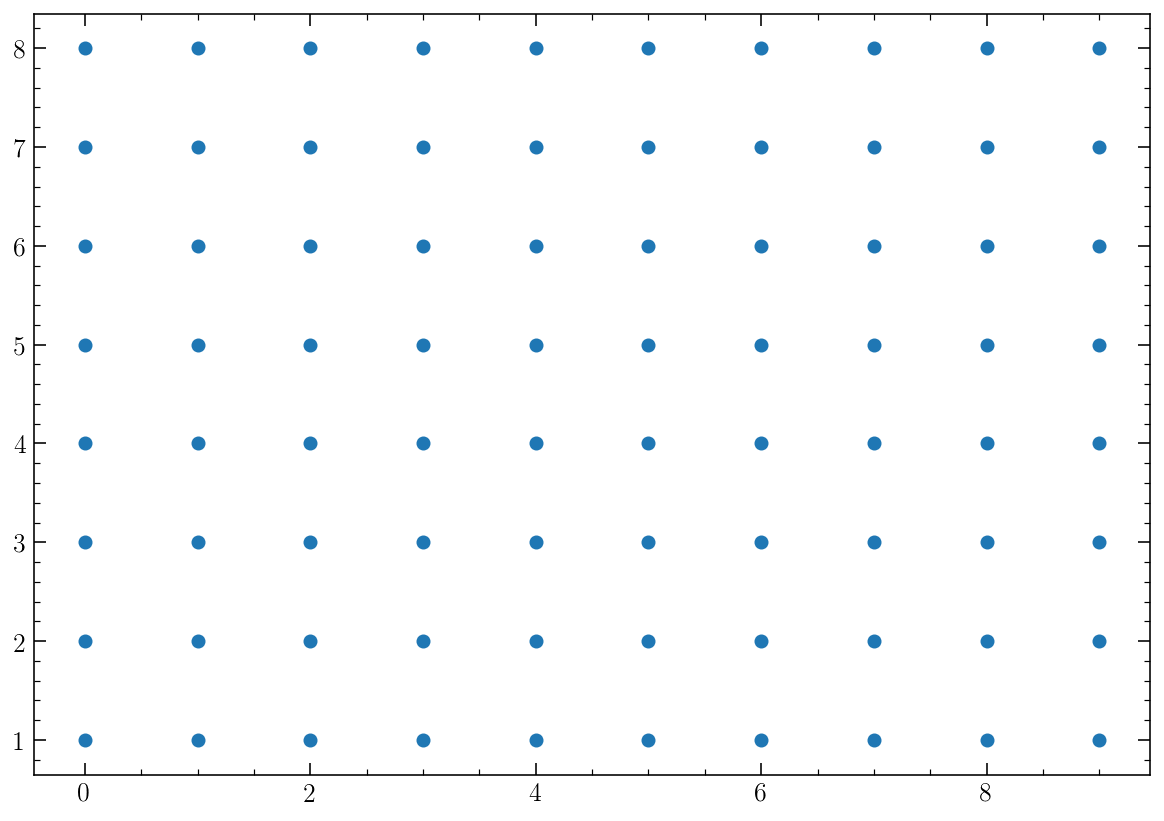

In [15]:
fig, ax = plot_system(lattice)

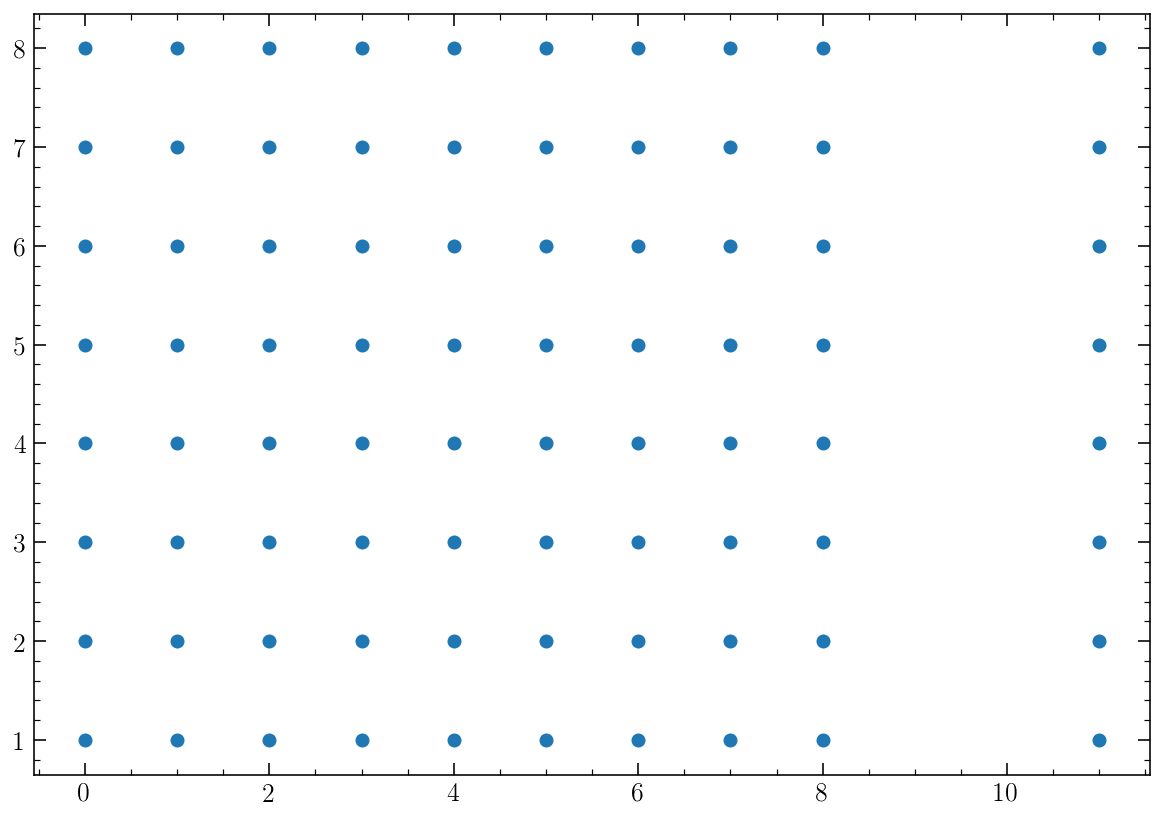

In [17]:
lattice[9, :, 0] += 1
fig, ax = plot_system(lattice)

In [18]:
ts, ys = int_n_model(lattice, massList, sep, 0.01, tf=15, b=1, k=10)

100%|██████████| 1500/1500 [00:03<00:00, 394.69it/s]


In [27]:
animate_system('PresentationAnimations/StretchAndRelease.mp4', ys, skip=5)

100%|██████████| 1501/1501 [00:44<00:00, 34.01it/s]


In [12]:
playVideo('PresentationAnimations/StretchAndRelease.mp4')

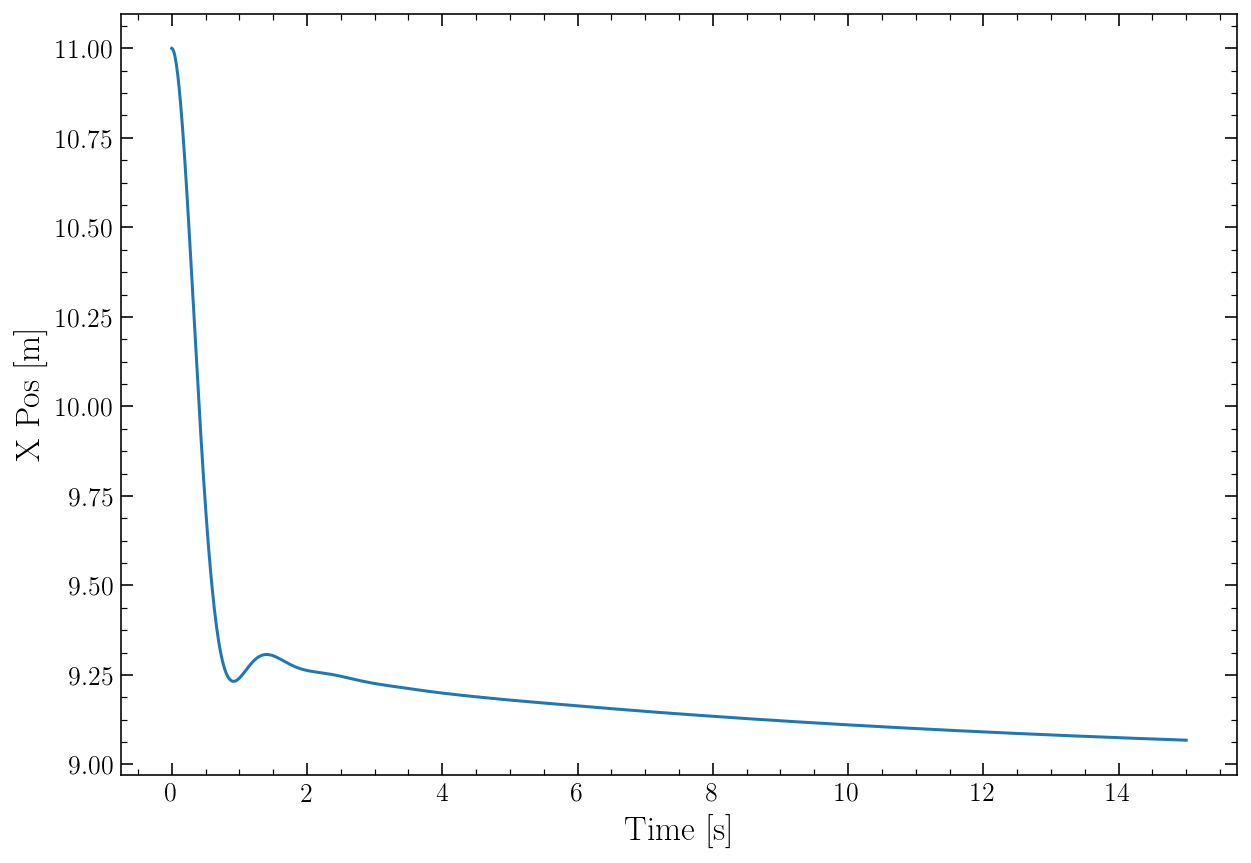

In [31]:
fig = plt.figure(figsize=(10, 7))
plt.plot(ts, ys[:, -1, 0, 0])
plt.xlabel('Time [s]', fontsize=17)
plt.ylabel('X Pos [m]', fontsize=17)
plt.savefig('PresentationFigures/StretchAndReleaseXpos.png', dpi=350, bbox_inches='tight')

<center><h3>This is an overdamped system</h3></center>

<center><img src="PresentationFigures/StretchAndReleaseXpos.png" alt="Drawing" style="width: 750px;"/></center>

<h3>Calculation of Youngs Modulus</h3>
Recall that:

$$
E = \frac{Stress}{Strain}
$$

$$
Stress = \frac{A}{F} \;\;\;\;\;\;\;\;\;\;\;\;\;\;Strain = \frac{\Delta L}{L}
$$

<h3>Method</h3>
We want to measure youngs modulus for the material and see how it varies with spring constant

    1) Pin one end of the solid
    2) Apply a constant force to the other over some integration with a given spring constant
    3) Measure the change in length and calculate the strain to get Youngs Modulus
    4) Repeat 2-3 for a set of spring constants

In [13]:
playVideo('PresentationAnimations/ConstantForce.mp4')

In [33]:
def get_strain(ys):
    Li = np.mean(ys[0, -1, :, 0]-ys[0, 0, :, 0])
    Lf = np.mean(ys[-1, -1, :, 0]-ys[-1, 0, :, 0])
    dL = Lf-Li
    return dL/Li

In [34]:
def get_stress(ys, F):
    A = ys[-1, -1, -1, 1]-ys[-1, -1, 0, 1]
    FMag = np.sqrt(F[0]**2+F[1]**2)
    return FMag/A

In [35]:
def get_youngs_modulus(ys, F):
    return get_stress(ys, F)/get_strain(ys)

In [38]:
ea = list()
K = np.linspace(1, 20, 100)
F = np.array([10, 0])
for k in tqdm(K):
    ts, ys = int_n_model(lattice, massList, sep, 0.01, tf=15, b=1, k=k, F=F, pbar=False)
    ea.append(get_youngs_modulus(ys, F))

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


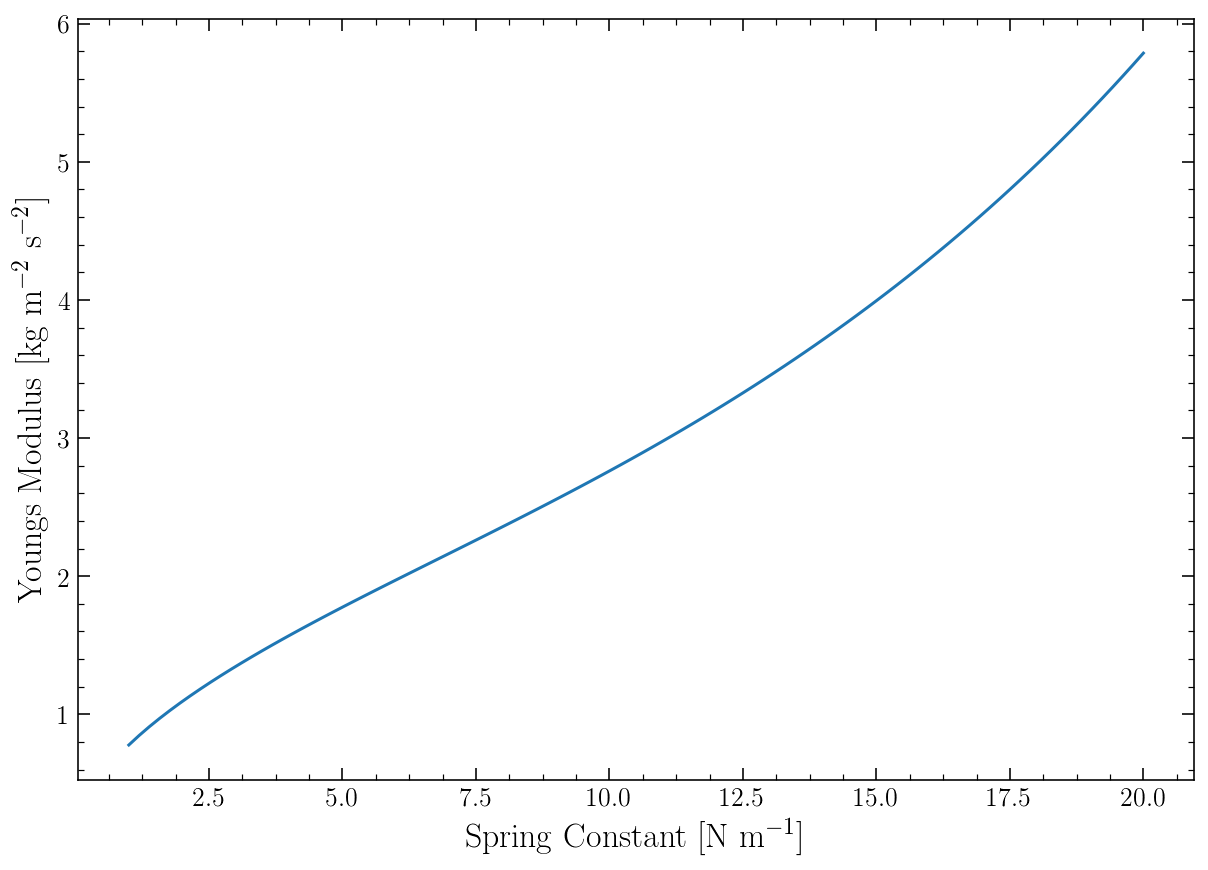

In [43]:
plt.figure(figsize=(10, 7))
plt.plot(np.linspace(1, 20, 100), ea)
plt.xlabel(r'Spring Constant [N m$^{-1}$]', fontsize=17)
plt.ylabel(r'Youngs Modulus [kg m$^{-2}$ s$^{-2}$]', fontsize=17)
plt.savefig('PresentationFigures/YoungsModulusVsK.png', dpi=350, bbox_inches='tight')

<h3>Set of spring constants</h3>

In [ ]:
for k in tqdm(np.linspace(1, 20, 100)):
    ts, ys = int_n_model(lattice, massList, sep, 0.01, tf=15, b=1, k=k, F=F, pbar=False)
    e.append(get_youngs_modulus(ys, F))

<center><img src="PresentationFigures/YoungsModulusVsK.png" alt="Drawing" style="width: 750px;"/></center>

<h3>Coefficient of Restitution</h3>

No results yet

Will reverse the momentum of the bottom row of springs when the entire solid has some velocity

<h2>Honors Project</h2>

nbody simulations are naievly an $O(n^{2})$ calculations

python is slow when running for loops

<h3>Ways around this</h3>
    
    1) Ignore it, just use pure Python
    2) Use numpy for a small speed increase
    3) Make your code a little more C like and use numba
    4) Use pycuda
    5) just give in, rewrite it in C, and the pure CUDA, and
       then drop out of College, I bet Home Depot is Hiring.

I never used pure python, but I will make a speed comparision between 2-5

In [44]:
times = {'Numpy': 723, 'Numba': 20, 'PyCUDA': 1.6, 'C': 1.52, 'CUDA': 0.59}

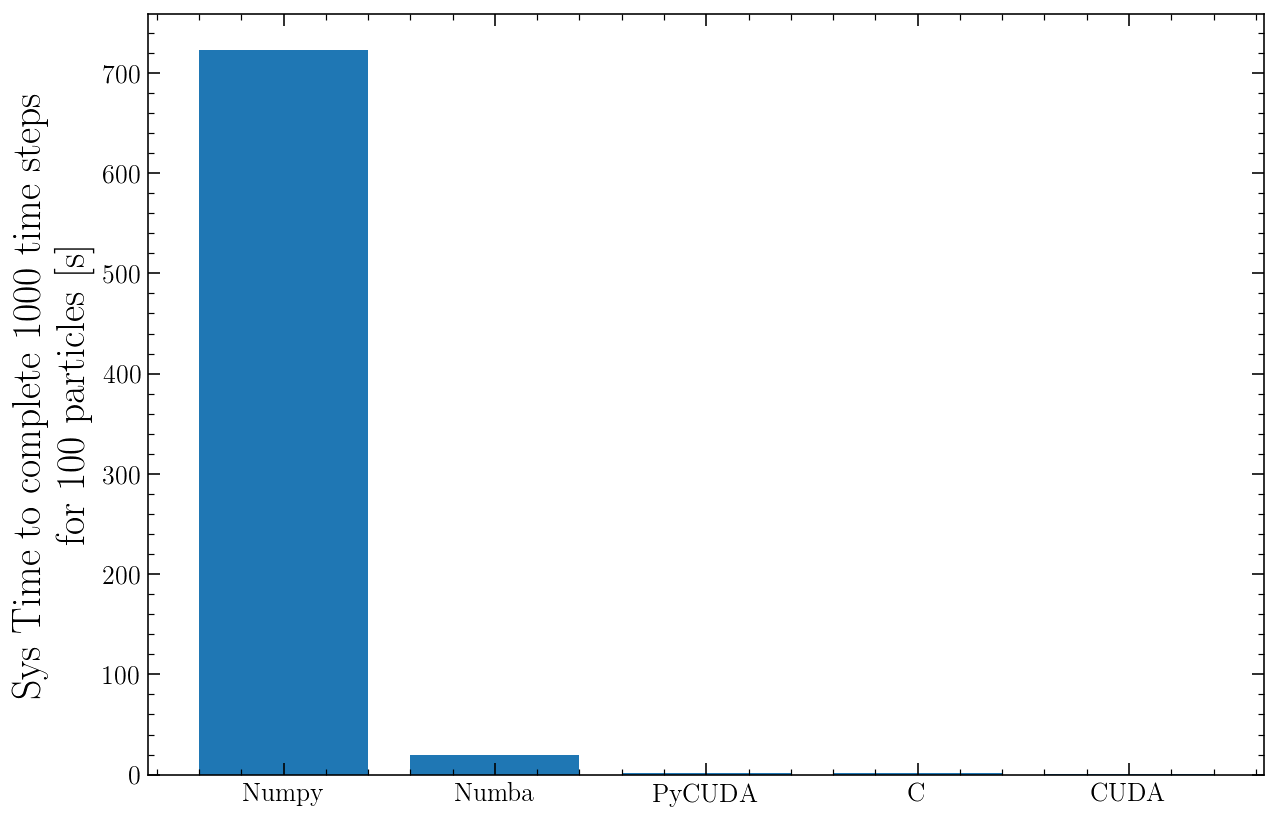

In [54]:
fig = plt.figure(figsize=(10, 7))
plt.bar(range(len(times)), list(times.values()), align='center')
plt.xticks(range(len(times)), list(times.keys()))
plt.ylabel('Sys Time to complete 1000 time steps\nfor 100 particles [s]', fontsize=20)
plt.savefig('PresentationFigures/TimesWithNumpy.png', dpi=350, bbox_inches='tight')

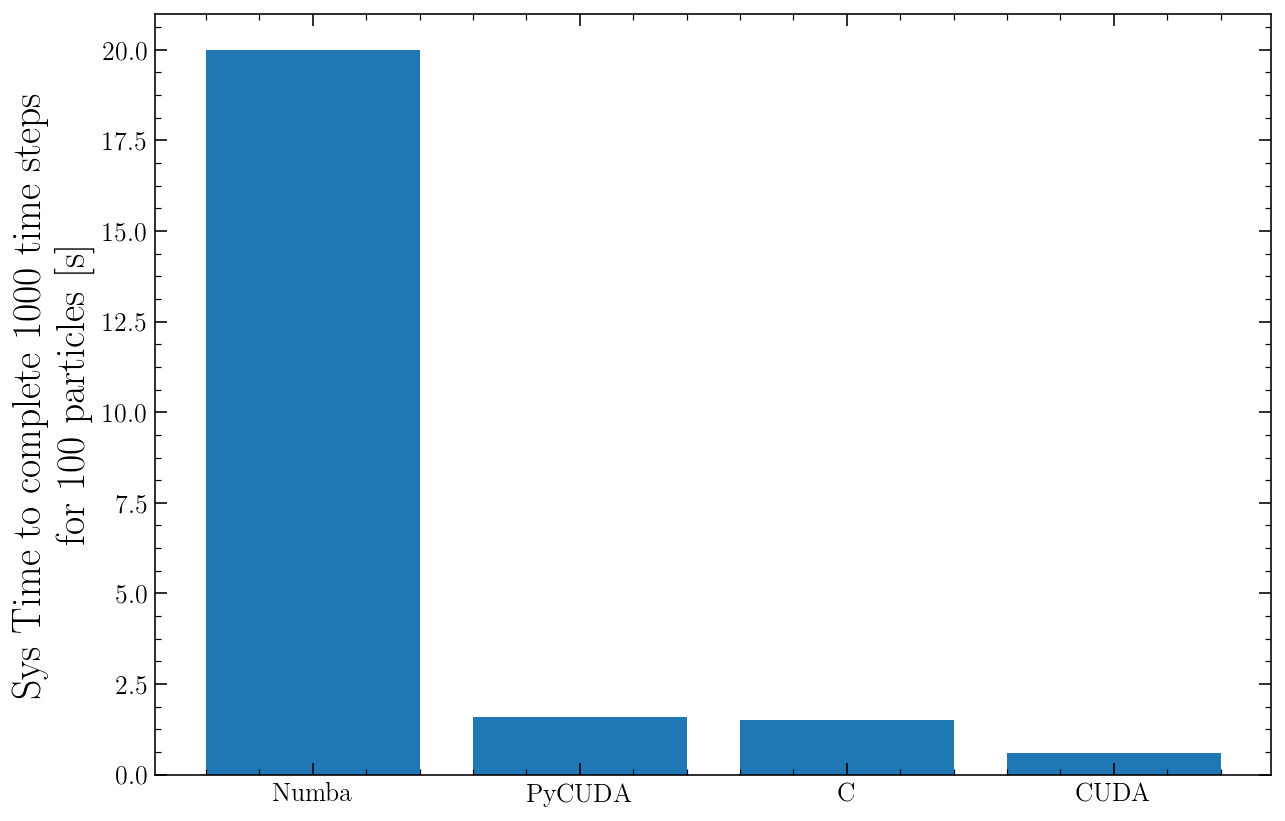

In [55]:
times = {'Numba': 20, 'PyCUDA': 1.6, 'C': 1.52, 'CUDA': 0.59}
fig = plt.figure(figsize=(10, 7))
plt.bar(range(len(times)), list(times.values()), align='center')
plt.xticks(range(len(times)), list(times.keys()))
plt.ylabel('Sys Time to complete 1000 time steps\nfor 100 particles [s]', fontsize=20)
plt.savefig('PresentationFigures/TimesWithNumba.png', dpi=350, bbox_inches='tight')

<h3>Code Timing</h3>

<center><img src="PresentationFigures/TimesWithNumpy.png" alt="Drawing" style="width: 1000px;"/></center>

<center><img src="PresentationFigures/TimesWithNumba.png" alt="Drawing" style="width: 1000px;"/></center>

<h3>So What Should I, the aspiring nbody integrator, do</h3>

Using just numpy is slow, so if you need a big simulation whats the best way to get that?

Numba is the slowest of the "fast" methods, but also the easiest, it is nearly a drop in solution.

PyCUDA C and CUDA all take an enourmous amount of effort, so unless you need to scale your simulations massivly I recomment staying away from these.

<center>Questions?</center>

<h2>Works Consulted</h2>

    1) http://hyperphysics.phy-astr.gsu.edu/hbase/permot3.html
    2) https://documen.tician.de/pycuda/
    3) https://docs.nvidia.com/cuda/